In [2]:
from PIL import Image
import tensorflow as tf
import scipy.ndimage
from scipy import misc

from scipy.interpolate import RectBivariateSpline
import numpy as np
import numpy.matlib as ml
import random
import time
import os
import gc
import scipy.io

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("C:/Users/fedor/.conda/envs/tf-gpu/Lib/site-packages/tensorflow/contrib/slim")

C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework

In [3]:
tf.reset_default_graph()
slim = tf.contrib.slim

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
print("starting the job...")

num_out = 5    #number ouf output parameters being predicted

global numpix_side 
numpix_side = 192   #number of image pixels on the side

global max_noise_rms, max_psf_rms , max_cr_intensity
max_trainoise_rms = 0.1 # maximum rms of noise in training data
max_testnoise_rms = 0.1 # maximum rms of noise in test or validation data
max_noise_rms = max_testnoise_rms

max_psf_rms = 0.08/0.04  # maximum Gaussian PSF rms (in pixels)
max_cr_intensity = 0.5 # maximum scaling for cosmic ray and artefact maps

global constant_noise_rms
variable_noise_rms = True  #if True, the noise rms will be chosen randomly for each sample with a max of max_noise_rms (above)

global pix_res
pix_res = 0.04 # pixel size in arcsec
L_side = pix_res * numpix_side

global arcs_data_path_1, arcs_data_path_2 , test_data_path_1 , test_data_path_2 , CRay_data_path
global lens_data_path_1, lens_data_path_2, testlens_data_path_1, testlens_data_path_2 

global min_unmasked_flux 
min_unmasked_flux = 0.75

#number of folders containing training or test data. If all 3 point to the same folder that's OK (only that folder will be used).
global num_data_dirs
num_data_dirs = 3

num_training_samples = 79992

PATH_train = 'D:/'
PATH_test = 'D:/'

arcs_data_path_1 = PATH_train + 'lensed_images/'
arcs_data_path_2 = arcs_data_path_1
arcs_data_path_3 = arcs_data_path_1

test_data_path_1 = PATH_test + 'lensed_images_test/'
test_data_path_2 = test_data_path_1
test_data_path_3 = test_data_path_1

lens_data_path_1 = PATH_train + 'lensed_images/'
lens_data_path_2 = lens_data_path_1
lens_data_path_3 = lens_data_path_1

testlens_data_path_1 = PATH_test + 'lensed_images_test/'
testlens_data_path_2 = testlens_data_path_1
testlens_data_path_3 = testlens_data_path_1

#folder containing cosmic rays
CRay_data_path   = '../../data_Ensai/CosmicRays/'

global max_xy_range   # xy range of center of the lens. The image is shifted in a central area with a side of max_xy_range (arcsec) during training or testing
max_xy_range = 0.5

starting the job...


In [5]:
exec(open("get_data.py").read())

In [6]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% MODEL DEFINITION

x = tf.placeholder(tf.float32, shape=[None, numpix_side*numpix_side])   #placeholder for input image
y_ = tf.placeholder(tf.float32, shape=[None,num_out])    #placeholder for output parameters during training
x_image0 = tf.reshape(x, [-1,numpix_side,numpix_side,1])

# removing image intensity bias: filter image with a 4X4 filter and remove from image
MASK = tf.abs(tf.sign(x_image0))
XX =  x_image0 +  ( (1-MASK) * 1000.0)
bias_measure_filt = tf.constant((1.0/16.0), shape=[4, 4, 1, 1])
bias_measure = tf.nn.conv2d( XX , bias_measure_filt , strides=[1, 1, 1, 1], padding='VALID')
im_bias = tf.reshape( tf.reduce_min(bias_measure,axis=[1,2,3]) , [-1,1,1,1] )
x_image = x_image0 - (im_bias * MASK )
x_input = tf.concat([x_image,x_image,x_image], axis=3)

In [7]:
# construct models
exec(open("ensai_model.py").read())

In [8]:
with tf.variable_scope("ENSAI"):
    #x_input = slim.conv2d(x_image, 3,(3,3),padding='same', scope = 'new')    # x has a dimension of (IMG_SIZE,IMG_SIZE,3) 
    y_out = model_9(x_input,scope="model_9")

In [9]:
variables_to_restore =  slim.get_variables_to_restore(exclude=['ENSAI/model_9/fc8', 'ENSAI/new',\
                                                               'ENSAI/model_9/fc7', 'ENSAI/model_9/fc6'])

In [10]:
variables_to_restore

[<tf.Variable 'ENSAI/model_9/conv1/weights:0' shape=(11, 11, 3, 64) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv2/weights:0' shape=(5, 5, 64, 192) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv2/biases:0' shape=(192,) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv3/weights:0' shape=(3, 3, 192, 384) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv3/biases:0' shape=(384,) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv4/weights:0' shape=(3, 3, 384, 384) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv4/biases:0' shape=(384,) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv5/weights:0' shape=(3, 3, 384, 256) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv5/biases:0' shape=(256,) dtype=float32_ref>]

In [11]:
def rename_2(var):
    return var.op.name.replace("ENSAI/model_9", "alexnet_v2")

In [12]:
variables_to_save =  slim.get_variables(scope="ENSAI")   #list of variables to save
variables_to_restore = {rename_2(var):var for var in variables_to_restore}
train_pars = variables_to_restore  #list of parameters to train

In [13]:
variables_to_restore

{'alexnet_v2/conv1/weights': <tf.Variable 'ENSAI/model_9/conv1/weights:0' shape=(11, 11, 3, 64) dtype=float32_ref>,
 'alexnet_v2/conv1/biases': <tf.Variable 'ENSAI/model_9/conv1/biases:0' shape=(64,) dtype=float32_ref>,
 'alexnet_v2/conv2/weights': <tf.Variable 'ENSAI/model_9/conv2/weights:0' shape=(5, 5, 64, 192) dtype=float32_ref>,
 'alexnet_v2/conv2/biases': <tf.Variable 'ENSAI/model_9/conv2/biases:0' shape=(192,) dtype=float32_ref>,
 'alexnet_v2/conv3/weights': <tf.Variable 'ENSAI/model_9/conv3/weights:0' shape=(3, 3, 192, 384) dtype=float32_ref>,
 'alexnet_v2/conv3/biases': <tf.Variable 'ENSAI/model_9/conv3/biases:0' shape=(384,) dtype=float32_ref>,
 'alexnet_v2/conv4/weights': <tf.Variable 'ENSAI/model_9/conv4/weights:0' shape=(3, 3, 384, 384) dtype=float32_ref>,
 'alexnet_v2/conv4/biases': <tf.Variable 'ENSAI/model_9/conv4/biases:0' shape=(384,) dtype=float32_ref>,
 'alexnet_v2/conv5/weights': <tf.Variable 'ENSAI/model_9/conv5/weights:0' shape=(3, 3, 384, 256) dtype=float32_ref>

In [14]:
save_file = './ckpt/alex_model_tl.ckpt'
restore_file = '../../data_Ensai/trained_weights/model_tl_alex.ckpt'   #path of network weights file to restore from

RESTORE = True
SAVE = True
restorer = tf.train.Saver(variables_to_restore)
saver = tf.train.Saver(variables_to_save)

# ############## flipping and cost function
MeanSquareCost , y_out_flipped = cost_tensor(y_out)

In [15]:
reader = tf.train.NewCheckpointReader(restore_file)
reader.get_variable_to_shape_map()

{'alexnet_v2/conv1/weights': [11, 11, 3, 64],
 'alexnet_v2/fc8/weights/RMSProp_1': [1, 1, 4096, 1001],
 'alexnet_v2/fc8/biases/RMSProp_1': [1001],
 'alexnet_v2/conv5/weights/RMSProp': [3, 3, 384, 256],
 'alexnet_v2/conv5/biases/RMSProp': [256],
 'alexnet_v2/conv1/biases': [64],
 'alexnet_v2/conv1/weights/RMSProp': [11, 11, 3, 64],
 'alexnet_v2/conv1/weights/RMSProp_1': [11, 11, 3, 64],
 'alexnet_v2/conv5/weights': [3, 3, 384, 256],
 'alexnet_v2/conv5/biases': [256],
 'alexnet_v2/conv1/biases/RMSProp': [64],
 'alexnet_v2/conv1/biases/RMSProp_1': [64],
 'alexnet_v2/conv2/biases/RMSProp': [192],
 'alexnet_v2/conv2/biases/RMSProp_1': [192],
 'alexnet_v2/conv2/biases': [192],
 'alexnet_v2/conv2/weights': [5, 5, 64, 192],
 'alexnet_v2/conv2/weights/RMSProp': [5, 5, 64, 192],
 'alexnet_v2/conv2/weights/RMSProp_1': [5, 5, 64, 192],
 'alexnet_v2/conv3/biases': [384],
 'alexnet_v2/conv3/biases/RMSProp': [384],
 'alexnet_v2/fc6/weights/RMSProp': [5, 5, 256, 4096],
 'alexnet_v2/conv3/weights': [3,

### Training

In [16]:
############### OPTIMIZER:
learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(MeanSquareCost,var_list=train_pars)
##########################

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
min_eval_cost = 0.2
cycle_batch_size = 200
X = np.zeros((cycle_batch_size,numpix_side*numpix_side), dtype='float32') ;
Y = np.zeros((cycle_batch_size,num_out), dtype='float32' );
MAG = np.zeros((cycle_batch_size,1), dtype='float32' );

In [18]:
num_test_samples = 200 # number of test samples
max_num_test_samples = 10003

X_test = np.zeros((num_test_samples,numpix_side*numpix_side), dtype='float32'  );
Y_test = np.zeros((num_test_samples,num_out), dtype='float32' );
MAG_test = np.zeros((num_test_samples,1), dtype='float32' );
Predictions = np.zeros((num_test_samples , num_out ) , dtype='float32' )
# max_noise_rms = max_testnoise_rms

ind_t = range(num_test_samples)

In [19]:
read_data_batch(X_test, Y_test, MAG_test, max_num_test_samples, 'test')

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if RESTORE:
    restorer.restore(sess, restore_file)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../../data_Ensai/trained_weights/model_tl_alex.ckpt


In [21]:
model_num = '_AlexNet_reinforcment'
num_iterations = int(num_training_samples/cycle_batch_size)
max_file_num = 79991

In [22]:
num_training_samples

79992

In [23]:
num_iterations

399

In [24]:
log_file = open("log_file.txt","w")
log_file.close()

In [ ]:
write_time = time.time()
start_time = time.time()
print_per = 1

costs = []
seed = 0

In [25]:
start_time = time.time()

for num_epoch in range(1):
    for i in range(num_iterations):
        seed += 1 

        read_data_batch( X , Y , MAG , max_file_num , 'train', seed)
        sess.run(train_step, feed_dict={x: X, y_: Y})
        
        if i%200 == 0:     
            train_cost = sess.run(MeanSquareCost, feed_dict={x: X, y_: Y} )
            costs.append(train_cost)

            sum_rms = 0
            eval_cost = 0
            chunk_size = 50
            num_chunks = int(num_test_samples/chunk_size)
            for it in range(num_chunks):
                    eval_cost  = eval_cost + sess.run(MeanSquareCost, feed_dict={x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]], y_: Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]})
                    A = sess.run(y_out , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                    B = sess.run(y_out_flipped , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                    Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] = get_rotation_corrected(A,B,Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])
                    sum_rms = sum_rms + np.std(Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]- \
                                               Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:],axis=0)
            eval_cost = eval_cost / num_chunks
            print("mod"+ str(model_num) + ", lr: " + str(learning_rate) + ", "  + np.array_str( sum_rms/num_chunks  ,precision=2) )


        # show the iteration number, training cost, validation cost, and the average time per iteration for training
            print("                                         %0.4d  %0.5f %0.5f    %0.5f    %0.5f   %0.3f"%(num_epoch, i, train_cost,eval_cost,min_eval_cost,(time.time()-start_time)/print_per)) 
            start_time = time.time()

            log_file = open("log_file.txt","a")
            log_file.write('%d ' % (num_epoch) + ' '.join(map(str,sum_rms/num_chunks)) + ' %0.5f %0.5f\n' % (train_cost,eval_cost) )
            log_file.close()               

            if  SAVE & (eval_cost<min_eval_cost): # save file when validation cost drops
                    print("saving weights to the disk (eval) ...")
                    save_path = saver.save(sess, save_file)
                    print("done.")
            min_eval_cost = np.minimum(min_eval_cost,eval_cost)

mod_AlexNet_reinforcment, lr: 0.001, [0.78 0.35 0.36 0.16 0.16]
                                         0000  0.00000 0.54209    0.56075    0.20000   13.030
mod_AlexNet_reinforcment, lr: 0.001, [0.14 0.12 0.2  0.09 0.1 ]
                                         0000  200.00000 0.01437    0.01993    0.20000   581.772
saving weights to the disk (eval) ...
done.
mod_AlexNet_reinforcment, lr: 0.001, [0.11 0.1  0.17 0.09 0.09]
                                         0001  0.00000 0.00977    0.01534    0.01993   602.853
saving weights to the disk (eval) ...
done.
mod_AlexNet_reinforcment, lr: 0.001, [0.09 0.09 0.15 0.08 0.09]
                                         0001  200.00000 0.01001    0.01151    0.01534   601.835
saving weights to the disk (eval) ...
done.
mod_AlexNet_reinforcment, lr: 0.001, [0.09 0.09 0.14 0.08 0.08]
                                         0002  0.00000 0.00961    0.01081    0.01151   602.531
saving weights to the disk (eval) ...
done.
mod_AlexNet_reinforcment, 

In [31]:
start_time = time.time()

for num_epoch in range(1):
    for i in range(num_iterations):
        seed += 1 

        read_data_batch( X , Y , MAG , max_file_num , 'train', seed)
        sess.run(train_step, feed_dict={x: X, y_: Y})
        
        if i%200 == 0:     
            train_cost = sess.run(MeanSquareCost, feed_dict={x: X, y_: Y} )
            costs.append(train_cost)

            sum_rms = 0
            eval_cost = 0
            chunk_size = 50
            num_chunks = int(num_test_samples/chunk_size)
            for it in range(num_chunks):
                    eval_cost  = eval_cost + sess.run(MeanSquareCost, feed_dict={x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]], y_: Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]})
                    A = sess.run(y_out , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                    B = sess.run(y_out_flipped , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                    Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] = get_rotation_corrected(A,B,Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])
                    sum_rms = sum_rms + np.std(Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]- \
                                               Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:],axis=0)
            eval_cost = eval_cost / num_chunks
            print("mod"+ str(model_num) + ", lr: " + str(learning_rate) + ", "  + np.array_str( sum_rms/num_chunks  ,precision=2) )


        # show the iteration number, training cost, validation cost, and the average time per iteration for training
            print("                                         %0.4d  %0.5f %0.5f    %0.5f    %0.5f   %0.3f"%(num_epoch, i, train_cost,eval_cost,min_eval_cost,(time.time()-start_time)/print_per)) 
            start_time = time.time()

            log_file = open("log_file.txt","a")
            log_file.write('%d ' % (num_epoch) + ' '.join(map(str,sum_rms/num_chunks)) + ' %0.5f %0.5f\n' % (train_cost,eval_cost) )
            log_file.close()               

            if  SAVE & (eval_cost<min_eval_cost): # save file when validation cost drops
                    print("saving weights to the disk (eval) ...")
                    save_path = saver.save(sess, save_file)
                    print("done.")
            min_eval_cost = np.minimum(min_eval_cost,eval_cost)

mod_AlexNet_reinforcment, lr: 0.001, [0.08 0.08 0.14 0.07 0.08]
                                         0000  0.00000 0.00519    0.00910    0.00964   4.906
saving weights to the disk (eval) ...
done.
mod_AlexNet_reinforcment, lr: 0.001, [0.08 0.08 0.15 0.07 0.07]
                                         0000  200.00000 0.00555    0.00942    0.00910   641.900


In [35]:
start_time = time.time()

for num_epoch in range(3):
    for i in range(num_iterations):
        seed += 1 

        read_data_batch( X , Y , MAG , max_file_num , 'train', seed)
        sess.run(train_step, feed_dict={x: X, y_: Y})
        
        if i%200 == 0:     
            train_cost = sess.run(MeanSquareCost, feed_dict={x: X, y_: Y} )
            costs.append(train_cost)

            sum_rms = 0
            eval_cost = 0
            chunk_size = 50
            num_chunks = int(num_test_samples/chunk_size)
            for it in range(num_chunks):
                    eval_cost  = eval_cost + sess.run(MeanSquareCost, feed_dict={x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]], y_: Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]})
                    A = sess.run(y_out , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                    B = sess.run(y_out_flipped , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                    Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] = get_rotation_corrected(A,B,Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])
                    sum_rms = sum_rms + np.std(Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]- \
                                               Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:],axis=0)
            eval_cost = eval_cost / num_chunks
            print("mod"+ str(model_num) + ", lr: " + str(learning_rate) + ", "  + np.array_str( sum_rms/num_chunks  ,precision=2) )


        # show the iteration number, training cost, validation cost, and the average time per iteration for training
            print("                                         %0.4d  %0.5f %0.5f    %0.5f    %0.5f   %0.3f"%(num_epoch, i, train_cost,eval_cost,min_eval_cost,(time.time()-start_time)/print_per)) 
            start_time = time.time()

            log_file = open("log_file.txt","a")
            log_file.write('%d ' % (num_epoch) + ' '.join(map(str,sum_rms/num_chunks)) + ' %0.5f %0.5f\n' % (train_cost,eval_cost) )
            log_file.close()               

            if  SAVE & (eval_cost<min_eval_cost): # save file when validation cost drops
                    print("saving weights to the disk (eval) ...")
                    save_path = saver.save(sess, save_file)
                    print("done.")
            min_eval_cost = np.minimum(min_eval_cost,eval_cost)

mod_AlexNet_reinforcment, lr: 0.001, [0.09 0.08 0.13 0.07 0.07]
                                         0000  0.00000 0.00600    0.00881    0.00910   4.835
saving weights to the disk (eval) ...
done.
mod_AlexNet_reinforcment, lr: 0.001, [0.08 0.09 0.13 0.08 0.07]
                                         0000  200.00000 0.00489    0.00851    0.00881   626.265
saving weights to the disk (eval) ...
done.
mod_AlexNet_reinforcment, lr: 0.001, [0.08 0.07 0.13 0.07 0.07]
                                         0001  0.00000 0.00449    0.00783    0.00851   604.875
saving weights to the disk (eval) ...
done.
mod_AlexNet_reinforcment, lr: 0.001, [0.08 0.08 0.13 0.07 0.07]
                                         0001  200.00000 0.00456    0.00793    0.00783   595.148
mod_AlexNet_reinforcment, lr: 0.001, [0.07 0.08 0.11 0.07 0.07]
                                         0002  0.00000 0.00470    0.00720    0.00783   585.860
saving weights to the disk (eval) ...
done.
mod_AlexNet_reinforcment, l

In [37]:
start_time = time.time()

for num_epoch in range(3):
    for i in range(num_iterations):
        seed += 1 

        read_data_batch( X , Y , MAG , max_file_num , 'train', seed)
        sess.run(train_step, feed_dict={x: X, y_: Y})
        
        if i%200 == 0:     
            train_cost = sess.run(MeanSquareCost, feed_dict={x: X, y_: Y} )
            costs.append(train_cost)

            sum_rms = 0
            eval_cost = 0
            chunk_size = 50
            num_chunks = int(num_test_samples/chunk_size)
            for it in range(num_chunks):
                    eval_cost  = eval_cost + sess.run(MeanSquareCost, feed_dict={x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]], y_: Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]})
                    A = sess.run(y_out , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                    B = sess.run(y_out_flipped , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                    Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] = get_rotation_corrected(A,B,Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])
                    sum_rms = sum_rms + np.std(Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]- \
                                               Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:],axis=0)
            eval_cost = eval_cost / num_chunks
            print("mod"+ str(model_num) + ", lr: " + str(learning_rate) + ", "  + np.array_str( sum_rms/num_chunks  ,precision=2) )


        # show the iteration number, training cost, validation cost, and the average time per iteration for training
            print("                                         %0.4d  %0.5f %0.5f    %0.5f    %0.5f   %0.3f"%(num_epoch, i, train_cost,eval_cost,min_eval_cost,(time.time()-start_time)/print_per)) 
            start_time = time.time()

            log_file = open("log_file.txt","a")
            log_file.write('%d ' % (num_epoch) + ' '.join(map(str,sum_rms/num_chunks)) + ' %0.5f %0.5f\n' % (train_cost,eval_cost) )
            log_file.close()               

            if  SAVE & (eval_cost<min_eval_cost): # save file when validation cost drops
                    print("saving weights to the disk (eval) ...")
                    save_path = saver.save(sess, save_file)
                    print("done.")
            min_eval_cost = np.minimum(min_eval_cost,eval_cost)

mod_AlexNet_reinforcment, lr: 0.001, [0.07 0.07 0.12 0.06 0.06]
                                         0000  0.00000 0.00404    0.00694    0.00687   5.066
mod_AlexNet_reinforcment, lr: 0.001, [0.07 0.07 0.12 0.06 0.06]
                                         0000  200.00000 0.00342    0.00678    0.00687   659.136
saving weights to the disk (eval) ...
done.
mod_AlexNet_reinforcment, lr: 0.001, [0.06 0.07 0.12 0.06 0.06]
                                         0001  0.00000 0.00316    0.00648    0.00678   599.525
saving weights to the disk (eval) ...
done.
mod_AlexNet_reinforcment, lr: 0.001, [0.06 0.07 0.12 0.06 0.06]
                                         0001  200.00000 0.00335    0.00643    0.00648   609.692
saving weights to the disk (eval) ...
done.
mod_AlexNet_reinforcment, lr: 0.001, [0.06 0.07 0.11 0.06 0.06]
                                         0002  0.00000 0.00338    0.00613    0.00643   596.356
saving weights to the disk (eval) ...
done.
mod_AlexNet_reinforcment, l

In [39]:
start_time = time.time()

for num_epoch in range(3):
    for i in range(num_iterations):
        seed += 1 

        read_data_batch( X , Y , MAG , max_file_num , 'train', seed)
        sess.run(train_step, feed_dict={x: X, y_: Y})
        
        if i%200 == 0:     
            train_cost = sess.run(MeanSquareCost, feed_dict={x: X, y_: Y} )
            costs.append(train_cost)

            sum_rms = 0
            eval_cost = 0
            chunk_size = 50
            num_chunks = int(num_test_samples/chunk_size)
            for it in range(num_chunks):
                    eval_cost  = eval_cost + sess.run(MeanSquareCost, feed_dict={x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]], y_: Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]})
                    A = sess.run(y_out , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                    B = sess.run(y_out_flipped , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                    Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] = get_rotation_corrected(A,B,Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])
                    sum_rms = sum_rms + np.std(Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]- \
                                               Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:],axis=0)
            eval_cost = eval_cost / num_chunks
            print("mod"+ str(model_num) + ", lr: " + str(learning_rate) + ", "  + np.array_str( sum_rms/num_chunks  ,precision=2) )


        # show the iteration number, training cost, validation cost, and the average time per iteration for training
            print("                                         %0.4d  %0.5f %0.5f    %0.5f    %0.5f   %0.3f"%(num_epoch, i, train_cost,eval_cost,min_eval_cost,(time.time()-start_time)/print_per)) 
            start_time = time.time()

            log_file = open("log_file.txt","a")
            log_file.write('%d ' % (num_epoch) + ' '.join(map(str,sum_rms/num_chunks)) + ' %0.5f %0.5f\n' % (train_cost,eval_cost) )
            log_file.close()               

            if  SAVE & (eval_cost<min_eval_cost): # save file when validation cost drops
                    print("saving weights to the disk (eval) ...")
                    save_path = saver.save(sess, save_file)
                    print("done.")
            min_eval_cost = np.minimum(min_eval_cost,eval_cost)

mod_AlexNet_reinforcment, lr: 0.001, [0.06 0.06 0.11 0.06 0.06]
                                         0000  0.00000 0.00334    0.00561    0.00549   5.142
mod_AlexNet_reinforcment, lr: 0.001, [0.06 0.06 0.1  0.06 0.06]
                                         0000  200.00000 0.00208    0.00555    0.00549   776.047
mod_AlexNet_reinforcment, lr: 0.001, [0.06 0.07 0.1  0.06 0.06]
                                         0001  0.00000 0.00416    0.00583    0.00549   679.898
mod_AlexNet_reinforcment, lr: 0.001, [0.07 0.07 0.1  0.06 0.06]
                                         0001  200.00000 0.00375    0.00617    0.00549   601.817
mod_AlexNet_reinforcment, lr: 0.001, [0.06 0.07 0.09 0.06 0.06]
                                         0002  0.00000 0.00316    0.00557    0.00549   589.236
mod_AlexNet_reinforcment, lr: 0.001, [0.06 0.07 0.12 0.06 0.07]
                                         0002  200.00000 0.00335    0.00651    0.00549   587.613


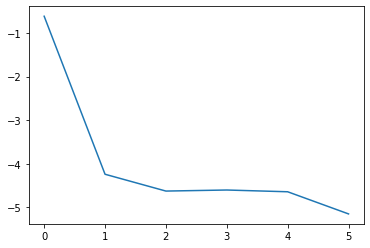

In [30]:
plt.plot(np.log(costs))

[-0.4, 0.4, -0.4, 0.4]

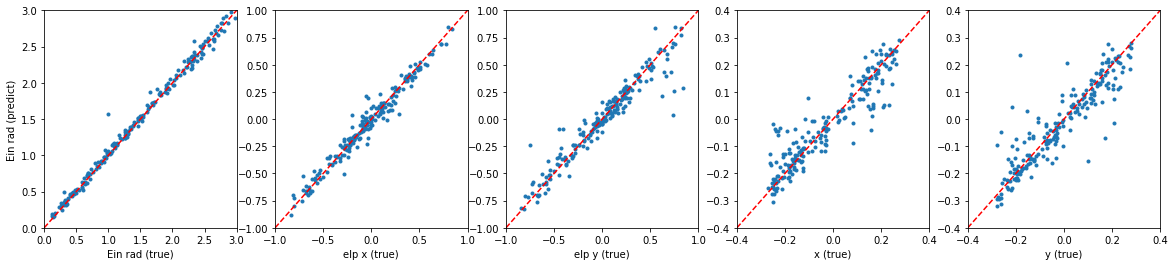

In [40]:
# And here's the fun part:
# plot the recovered parameters (y-axis) against their true values (x-axis)

plt.figure(figsize=(20, 4))
plt.subplot(1, 5, 1)
plt.plot(Y_test[:,0],Predictions[:,0],' .')
plt.plot([0 , 3.5],[0 , 3.5],'--r')
plt.xlabel("Ein rad (true)")
plt.ylabel("Ein rad (predict)")
plt.axis([0 ,3 ,0 ,3])

plt.subplot(1, 5, 2)
plt.plot(Y_test[:,1],Predictions[:,1],' .')
plt.plot([-1 , 1.],[-1 , 1.],'--r')
plt.xlabel("elp x (true)")
plt.axis([-1 ,1 ,-1 ,1])


plt.subplot(1, 5, 3)
plt.plot(Y_test[:,2],Predictions[:,2],' .')
plt.plot([-1 , 1.],[-1 , 1.],'--r')
plt.xlabel("elp y (true)")
plt.axis([-1 ,1 ,-1 ,1])


plt.subplot(1, 5, 4)
plt.plot(Y_test[:,3],Predictions[:,3],' .')
plt.plot([-0.4 , 0.4],[-0.4 , 0.4],'--r')
plt.xlabel("x (true)")
plt.axis([-0.4 ,0.4 ,-0.4 ,0.4])


plt.subplot(1, 5, 5)
plt.plot(Y_test[:,4],Predictions[:,4],' .')
plt.plot([-0.4 , 0.4],[-0.4 , 0.4],'--r')
plt.xlabel("y (true)")
plt.axis([-0.4 ,0.4 ,-0.4 ,0.4])

In [35]:
np.shape(Predictions[:,4])

(200,)

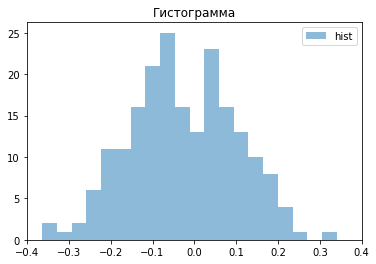

In [47]:
fig, ax = plt.subplots(1, 1)

#x = np.linspace(rayleigh.ppf(0.01), rayleigh.ppf(0.99), 1000)
#ax.plot(x, rayleigh.pdf(x), 'r-', label='rayleigh pdf')

plt.plot([-0.4 , 0.4],[-0.4 , 0.4],'--r')

#r = rayleigh.rvs(size = 1000)
ax.hist(Predictions[:,4], density = False, bins = 20, alpha = 0.5, label = 'hist')
ax.legend()
ax.set_title('Гистограмма')
ax.set_xlim(-0.4, 0.4)
plt.show()

In [52]:
p = np.percentile(Predictions[:,4], 67) # return 50th percentile, e.g median.
p

0.0372851695865394

In [51]:
p = np.percentile(Predictions[:,4], 33) # return 50th percentile, e.g median.
p

-0.08986973166465759

In [53]:
import scipy.stats as stats

In [55]:
N= 200

In [77]:
s_x = stats.sem(Y_test[:,4])
s_x

0.011278874929480627

In [78]:
s_y = stats.sem(Predictions[:,4])
s_y

0.008910059777801616

In [137]:
def conf_interval(pred, true, conf = 0.95):
    lower = []
    upper = []

    s_x = 1
    s_y = np.sqrt(np.sum(np.power((pred - true),2))/199)
    x_mean = np.mean(true)
    N = len(pred)
    t = scipy.stats.t.ppf((1-conf)/2, N-2)
    
    def lower_func(x, y, s_x, s_y, t, N, x_mean):
        return y - t*s_y*np.sqrt(1/N + (x-x_mean)**2/(N-1)/s_x**2)
    def upper_func(x, y, s_x, s_y, t, N, x_mean):
        return y + t*s_y*np.sqrt(1/N + (x-x_mean)**2/(N-1)/s_x**2)
        
    lower = [lower_func(x, y, s_x, s_y, t, N, x_mean) for y,x in zip(pred, true)]
    upper = [upper_func(x, y, s_x, s_y, t, N, x_mean) for y,x in zip(pred, true)]
    
    return lower,upper

In [130]:
np.sqrt(np.sum(np.power((Predictions[:,4] - Y_test[:,4]),2))/199)

0.14242788431673872

In [151]:
low, up = conf_interval(Predictions[:,2], Y_test[:,2], conf = 0.95)

In [80]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [71]:
resid = Y_test[:,4] - Predictions[:,4]
#  Estimate the standard errors:
sigma2_est = sum(resid**2) / (len(Y_test[:,4]) - 2)

x_mat = np.column_stack((np.ones(len(Y_test[:,4])), Y_test[:,4]))
x_new = x_mat
y_pred = Predictions[:,4]
# Calculate the prediction SE:
y_pred_se = np.linalg.inv(np.dot(np.transpose(x_mat), x_mat))
y_pred_se = np.dot(np.dot(x_new, y_pred_se), np.transpose(x_new))
y_pred_se = np.identity(len(x_new)) + y_pred_se
y_pred_se = sigma2_est * y_pred_se
y_pred_se = np.sqrt(np.diag(y_pred_se))


y_pred_lower = Predictions[:,4] - stats.t.ppf(q = 1 - 0.05 / 2, df = N-2) * y_pred_se
y_pred_upper = Predictions[:,4] + stats.t.ppf(q = 1 - 0.05 / 2, df = N-2) * y_pred_se

[-1, 1, -1, 1]

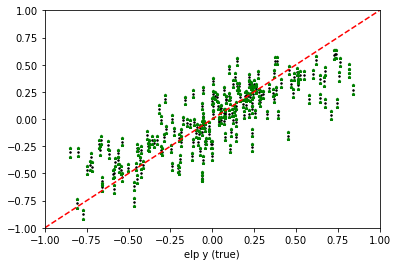

In [152]:
#plt.subplot(1, 5, 5)
plt.plot(Y_test[:,2], Predictions[:,2],'.k',markersize=3)
plt.plot(Y_test[:,2], low,'*g', markersize=3)
plt.plot(Y_test[:,2], up,'*g', markersize=3)

plt.plot([-1 , 1.],[-1 , 1.],'--r')
plt.xlabel("elp y (true)")
plt.axis([-1 ,1 ,-1 ,1])